### In this notebook we go through the process of training our model

We'll start by loading our data and encoding our categorical variables,  
since in our EDA process we saw that our data contains many unique values,  
it's best to use binary encoding over one-hot encoding

In addition to this, after some experimentation I've come to the conclusion  
that having the data in it's current form is not beneficial, I'll have to transform  
it back to the form of Artist : text, Genres: text[], so we will have to put in  
a form known as the transactional format

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import category_encoders as ce

ag_df = pd.read_csv('data/ag_data.csv')
ag_df.head()

AttributeError: module 'numpy' has no attribute 'round'

In [ ]:
ag_df2 = ag_df[~(ag_df['Subgenre'].str.contains('sleep'))].copy()

transactional_data = ag_df2.groupby('Artist')['Subgenre'].agg(list).reset_index()
transactional_data.head()

,Artist,Subgenre
0,!!!,"[alternative dance, dance rock, dance-punk, el..."
1,!T.O.O.H.!,[technical grindcore]
2,"""14""",[swedish rock-and-roll]
3,"""Cats"" 1981 Original London Cast",[show tunes]
4,"""DEMONS""","[action rock, punk 'n' roll, swedish garage rock]"


In [ ]:
transactional_data['Subgenre'] = transactional_data['Subgenre'].astype('string') 

In [ ]:
transactional_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34962 entries, 0 to 34961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Artist    34962 non-null  object
 1   Subgenre  34962 non-null  string
dtypes: object(1), string(1)
memory usage: 546.4+ KB


In [ ]:
transactional_data.to_csv('data/transactional_data.csv',index=False)

Now that our data is preprocessed we can begin with training our model,   
we're going to opt for K-Modes since we're dealing with categorical data,  
to choose the optimal amount of clusters we'll take a look at the elbow method

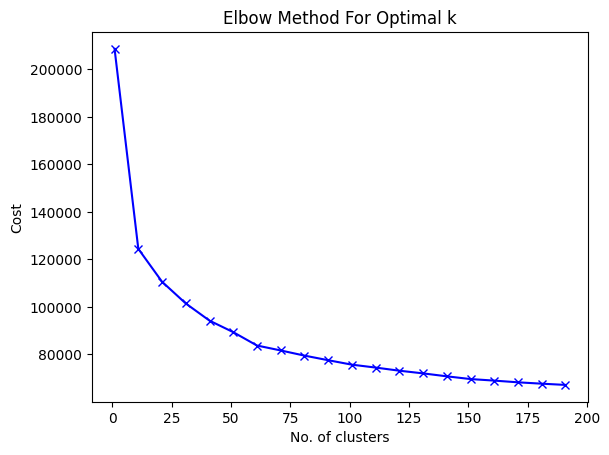

In [ ]:
from kmodes.kmodes import KModes
import matplotlib.pyplot as plt

encoder = ce.BinaryEncoder(cols=['Subgenre'])

d_enc = encoder.fit_transform(transactional_data)
X = d_enc.iloc[:,1:]

cost = []
K = range(1,200,10)
for num_clusters in list(K):
    kmode = KModes(n_clusters=num_clusters)
    kmode.fit_predict(X,n_init=5,init='Huang')
    cost.append(kmode.cost_)
    
plt.plot(K, cost, 'bx-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Method For Optimal k')
plt.show()

We'll opt for 75 as our number of clusters

In [ ]:
from kmodes.kmodes import KModes

km = KModes(n_clusters=75, init='Huang', n_init=5)
clusters = km.fit_predict(X)

for i in range(150):
    artists = transactional_data[clusters == i]['Artist'].tolist()
    print(f"Cluster {i+1}: {artists}")

Cluster 1: ['Andre Williams', 'Andrea Bertolini', 'Andy Z', 'Ane Brun', 'Angara', 'Anthony Naples', 'Anthony Rother', 'Anthony Shakir', 'Antichrist Siege Machine', 'Apoorva Sreejith', 'Apoptose', 'Appalachian Express', 'Aqours', 'Aqua', 'Archana Padhi', 'Archetypes Collide', 'Architectural', 'Aribert Reimann', 'Ariel Pink', 'Arif Sağ', 'Arijit Anand', 'Arjuna Schiks', 'Arkaik', 'Aux 88', 'Awon', 'Baby Do Brasil', 'Bad Omens', 'Bali Bandits', 'Banda Garota Safada', 'Banda Styllus', 'Barbra Streisand', 'Barcelona Gipsy balKan Orchestra', 'Barun Mishra', 'Barão Vermelho', 'Basic Tape', 'Bibhu Das', 'Bijay Anand Sahu', 'Bluegrass Brethren', 'Bluegrass Gospel Project', 'Bob Log III', 'Boris Way', 'Broken Back', 'CYNE', 'Catch Your Breath', 'Cavetown', 'Chandrabindoo', 'Chappell Roan', "Charlie Monroe's Boys", 'Chill Bump', 'Chiwoniso', 'Christine McLean & Vic Wilson', 'Christopher Jackson', 'Christopher Larkin', 'Chulbul Hota', 'Cidade Negra', 'Clandestino & Yailemm', 'Clannad', 'Clarence "